 # SCS1 (iPSC vs Others) dataset as example.

## import packages

2023-07-07 13:56:37.494886: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-07-07 13:56:43.860052: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-07-07 13:56:43.896208: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: NVIDIA GeForce GTX TITAN X computeCapability: 5.2
coreClock: 1.076GHz coreCount: 24 deviceMemorySize: 11.92GiB deviceMemoryBandwidth: 313.37GiB/s
2023-07-07 13:56:43.896234: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-07-07 13:56:43.898947: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-07-07 13:56:43.898997: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library li

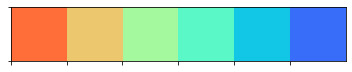

In [1]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


from aggmap import AggMap
from joblib import load,dump

from utils.dscarnet import dual_dscarnet
from utils.PCA_tool import PCA_transform
np.random.seed(888)

color = sns.color_palette("rainbow_r", 6) 
sns.palplot(color)


os.environ["CUDA_VISIBLE_DEVICES"]="0"
physical_gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)


## load data

In [2]:
df = pd.read_csv('dataset/SCS.csv').iloc[:,1:]
Y = pd.get_dummies(df['label']).values
Y

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]], dtype=uint8)

In [3]:
mp_sar = load('mp_example/scs_sar.mp')
X1 = load('mp_example/scs_x1.data')

## train a single path model

In [4]:
from utils.dscarnet import single_dscarnet

In [5]:
outer = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 8)
outer_idx = list(outer.split(X1,df['label']))
for i, idx in enumerate(outer_idx):
    
    train_idx, valid_idx = idx

    validY = Y[valid_idx]
    validX = X1[valid_idx]

    trainY = Y[train_idx]
    trainX = X1[train_idx]
    
    model = single_dscarnet(X1.shape[1:])
    opt = tf.keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #
    model.compile(optimizer = opt, loss = 'categorical_crossentropy',metrics=['accuracy'])


    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10,#for example
                                                      restore_best_weights=True)

    model.fit(trainX, trainY,
                              batch_size=128, 
                              epochs= 30,#for example 
                                verbose= 1, shuffle = True, 
                              validation_data = (validX, validY), 
                               callbacks=[early_stopping_cb],)
    break#for example

2023-07-07 13:56:45.022320: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-07 13:56:45.023910: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: NVIDIA GeForce GTX TITAN X computeCapability: 5.2
coreClock: 1.076GHz coreCount: 24 deviceMemorySize: 11.92GiB deviceMemoryBandwidth: 313.37GiB/s
2023-07-07 13:56:45.025517: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2023-07-07 13:56:45.025569: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-07-07 13:56:45.492635: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect

Epoch 1/30


2023-07-07 13:56:46.799590: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-07-07 13:56:47.143575: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8400
2023-07-07 13:56:47.662578: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-07-07 13:56:47.662985: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


55/55 [==============================] - 5s 44ms/step - loss: 7.0111 - accuracy: 0.6148 - val_loss: 6.1600 - val_accuracy: 0.6222
Epoch 2/30
55/55 [==============================] - 2s 31ms/step - loss: 5.6010 - accuracy: 0.6220 - val_loss: 5.0670 - val_accuracy: 0.6222
Epoch 3/30
55/55 [==============================] - 2s 31ms/step - loss: 4.6132 - accuracy: 0.6220 - val_loss: 4.1762 - val_accuracy: 0.6222
Epoch 4/30
55/55 [==============================] - 2s 31ms/step - loss: 3.8340 - accuracy: 0.6717 - val_loss: 3.5194 - val_accuracy: 0.7595
Epoch 5/30
55/55 [==============================] - 2s 31ms/step - loss: 3.2415 - accuracy: 0.8619 - val_loss: 3.0878 - val_accuracy: 0.8541
Epoch 6/30
55/55 [==============================] - 2s 31ms/step - loss: 2.8032 - accuracy: 0.8790 - val_loss: 2.5912 - val_accuracy: 0.9219
Epoch 7/30
55/55 [==============================] - 2s 31ms/step - loss: 2.4269 - accuracy: 0.9081 - val_loss: 2.2545 - val_accuracy: 0.9379
Epoch 8/30
55/55 [======

## explaination

In [6]:
from utils import explainer

In [7]:
#example, for more accurate result, pleas use 5-FCV model average S values
si_rank, _ = explainer.GlobalIMP(model, 
                                 mp=mp_sar, 
                                 X=trainX, Y=trainY,# use training set for explaination
                                    )

calculating feature importance for column 0 ...


100%|##########| 462/462 [08:42<00:00,  1.13s/it]


calculating feature importance for column 1 ...


100%|##########| 462/462 [08:28<00:00,  1.10s/it]


In [9]:
si_rank['class average'] = si_rank[['col_0_importance','col_1_importance']].mean(axis=1)
si_rank

,x,y,v,Subtypes,colors,col_0_importance,col_1_importance,class average
0,0,0,330.186,cluster_08,#b900ff,-0.301230,-0.301230,-0.301230
1,1,0,322.902,cluster_08,#b900ff,-0.450909,-0.450909,-0.450909
2,2,0,326.545,cluster_08,#b900ff,-0.747267,-0.747266,-0.747266
3,3,0,341.099,cluster_08,#b900ff,-0.835442,-0.835442,-0.835442
4,4,0,417.131,cluster_05,#00fff6,-0.254964,-0.254964,-0.254964
...,...,...,...,...,...,...,...,...
457,16,21,NaN-457,NaN,#000000,-0.321944,-0.321944,-0.321944
458,17,21,NaN-458,NaN,#000000,-0.321944,-0.321944,-0.321944
459,18,21,NaN-459,NaN,#000000,-0.321944,-0.321944,-0.321944
460,19,21,NaN-460,NaN,#000000,-0.321944,-0.321944,-0.321944


In [12]:
#example, for more accurate result, pleas use 5-FCV model average S values
si_rank.sort_values(by = ['class average'],ascending=False)

,x,y,v,Subtypes,colors,col_0_importance,col_1_importance,class average
47,5,2,746.361,cluster_08,#b900ff,5.693868,5.693868,5.693868
68,5,3,742.885,cluster_08,#b900ff,5.534274,5.534274,5.534274
340,4,16,634.433,cluster_05,#00fff6,5.030416,5.030416,5.030416
267,15,12,1117.34,cluster_09,#ff00ac,4.362708,4.362708,4.362708
287,14,13,1120.68,cluster_09,#ff00ac,3.838796,3.838796,3.838796
...,...,...,...,...,...,...,...,...
374,17,17,829.393,cluster_08,#b900ff,-0.980930,-0.980930,-0.980930
143,17,6,1010.04,cluster_06,#0074ff,-0.981769,-0.981769,-0.981769
115,10,5,1469.98,cluster_07,#2500ff,-0.983468,-0.983469,-0.983468
94,10,4,1354.03,cluster_07,#2500ff,-0.988121,-0.988121,-0.988121
